# DESeq Workshop 1 -  Standard Analyses for RNA-seq Data (unsupervised)


# Abstract

By Friday: Do we need to push this workshop out a week? Lets see where we are on Friday. Make a new repo and push this 
notebook to it, then use this notebook as a jumping off point to start working on the R package.

Note - the anova stuff should actually be a different workshop, but the mds pca things will go in this one.

This workshop summarizes the main approaches to analyzing sequencing data to obtain per-gene count data, but does not go through how to do it explicitly. It demonstrates approaches to summarizing count data using various Bioconductor annotation resources, followed by unsupervised exploratory data analysis. It introduces the (Ranged)SummarizedExperiment data class,  variance-stabilizing transformations, and the use of distances to visualize transcriptome shifts through methods such as Principal Components Analysis and Multidimensional Scaling.

This workshop uses quotes and materials from [RNA-seq workflow: gene-level exploratory analysis and differential expression](https://www.bioconductor.org/help/workflows/rnaseqGene/) by Love, Anders, Kim, and Huber.

This notebook is forked from [two notebooks originally created by Levi Waldron](https://github.com/compbiocore/bioconductor-workshop-2), with modifications to the text and code performed by Andrew Leith.  The The remaining material will be adapted into a second workshop on differential expression analysis with DESeq2 at a later date.

# Outline

1. Introduction to RNA-seq Data
    * What is RNAseq?
    * Quantifying expression
    * Differential expression
2. Initial Data Exploration
    * SummarizedExperiment 
    * Creating a SummarizedExperiment object from scratch
3. Filtering
4. Data Transformations  
    * log2  
    * rlog  
    * vst  
    * Transformation Visualization  
        * Boxplots  
        * Scatterplots  
5. Sample Heteogenity  
    * Heatmaps  
    * Component plots  
        * PCA plots  
        * MDS plots  

#  Introduction to RNAseq

## What is RNAseq?

The central dogma of biology refers to this concept that in general, information flows from DNA to RNA to proteins, which are the molecules that actually encode for various enzymes etc., that help a living organism maintain homeostasis and self-regulate. This flow of information can be managed at different stages. For this workshop, we are going to talk about studying the flow of information at the phase where DNA is trancsribed into RNA.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/fa/DNA_to_protein_or_ncRNA.svg/525px-DNA_to_protein_or_ncRNA.svg.png">

The general experimental process involves extracting RNA from your different experimental conditions, performing the library preparation steps (e.g., cDNA synthesis, fragmentation, and adding adapters). These libraries are applied to an Illumina FlowCell, where the sequencing actually occurs. The output from this process is these raw reads, which you can then align to the appropriate reference genome or transcriptome, where more reads will align to more highly expressed genes. This data can be processed to get back a counts matrix which will let you look at which genes are differentially expressed in different experimental conditions.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/97/Journal.pcbi.1004393.g002.png/2560px-Journal.pcbi.1004393.g002.png">

### Some more resources about sequencing technologies:
+ https://www.illumina.com/content/dam/illumina-marketing/documents/products/illumina_sequencing_introduction.pdf      
+ Rory Stark, Marta Grezlak, and James Hadfield. NA sequencing: the teenage years Nature Reviews Genetics *Nature Reviews Genetics* **20,** 631-656 (2019)      


##  Quantifying expression

The computational analysis of an RNA-seq experiment begins from the raw FASTQ files that contain the nucleotide sequence of each read and a quality score at each position. These reads are **aligned** to a reference genome or transcriptome. Some newer and very fast approaches can also estimate counts per transcript **without alignment**. For a paired-end sequencing run, raw data will include two FASTQ files and the software will require both FASTQ files. The output of this alignment step is commonly stored in a file format called SAM/BAM.

There are many different programs for running alignment-based quantification. Each alignment program will make different assumptions about the data and will show some variation in performance. For example, not all aligners are 'splice-aware', which means that they will recognize intron-sized gaps that are spliced from transcripts. Some popular alignment-based tools include [STAR](https://github.com/alexdobin/STAR), [HISAT2](https://daehwankimlab.github.io/hisat2/), [GSNAP/GMAP](http://research-pub.gene.com/gmap/), among many others. Counts can be generated from SAM/BAM alignments using programs such as [featureCounts](http://bioinf.wehi.edu.au/featureCounts/) or [HTSeq](https://htseq.readthedocs.io/en/master/). The information you get back from directly aligning RNAseq reads to the genome will be dependent on the quality of the annotations, which are not always great (especially for non-model organisms). 

Alignment-free tools have gained popularity for their fast performance and low memory requirements while maintaining good accuracy.  Instead of directly aligning RNA-seq reads to a reference genome, they perform "pseudo-alignment" by assigning reads to transcripts that contain compatible k-mers. The most popular of these tools are [Salmon](https://combine-lab.github.io) and [Kallisto](https://pachterlab.github.io/kallisto/). These generate a table of read counts directly without the need for a SAM/BAM file as a starting or intermediate step. 

The rest of this workshop assumes you are starting with the output of some sequence analysis pipeline (i.e. counts).


##  Differential expression

The differential expression analyses introduced here assume you are analyzing a raw counts table, where the rows are the genes or transcripts and the columns are your samples. It is always a good idea to read the documentation for any of these programs to make sure you understand what file formats should be used. The two most populat programs for  differential expression analyses are probably [DESeq2](http://bioconductor.org/packages/DESeq2) and [edgeR](http://bioconductor.org/packages/). Each program makes different assumptions and has different approaches to normalizing the data, and they will likely give you slightly different numbers of differentially expressed genes if you run both programs. 



# Initial data exploration


## SummarizedExperiment

SummarizedExperiment is a data class for representing RNA-seq data.

**The component parts of a *SummarizedExperiment* object.** 

* `assay(se)` or `assays(se)$counts` contains the matrix of counts
* `colData(se)` may contain data about the columns, e.g. patients or biological units
* `rowData(se)` may contain data about the rows, e.g. genes or transcript
* `rowRanges(se)` may contain genomic ranges for the genes/transcripts
* `metadata(se)` may contain information about the experiment



In [1]:
suppressPackageStartupMessages({
    library(airway)
    library(SummarizedExperiment)
})

For the purposes of this tutorial, we will be using a default dataset that is part of R's `airway` package.  The following command loads the `airway` dataset into our R environment:

In [ ]:
data(airway)

In [ ]:
airway

Use the `assay` function to access the counts matrix, where the rows are the genes, the columns are the samples, and the cells are the counts:

In [ ]:
head(assay(airway))

Use the `colData` function to see more information about each sample:

In [ ]:
head(colData(airway))

## Creating a SummarizedExperiment object from scratch

You can create `SummarizedExperiment` objects using the `SummarizedExperiment` function. The `assay` and `colData` arguments are required. 

In [ ]:
airway_counts <- assay(airway)
airway_samples <- colData(airway)
new_se <- SummarizedExperiment(assays = airway_counts, 
                               colData = airway_samples)
new_se

We can also add in the optional rowRanges data:

In [ ]:
airway_ranges <- rowRanges(airway)
new_se <- SummarizedExperiment(assays = airway_counts, 
                               colData = airway_samples, 
                               rowRanges = airway_ranges)
new_se

A metadata argument can also be added:

In [ ]:
airway_metadata <- metadata(airway)
new_se <- SummarizedExperiment(assays = airway_counts, 
                               colData = airway_samples, 
                               rowRanges = airway_ranges,
                               metadata = airway_metadata)
new_se

# Exploring the airway dataset

Once we have our fully annotated *SummarizedExperiment* object,
we can construct a *DESeqDataSet* object from it that will then form
the starting point of the analysis. Here, `~ cell + dex` means that we are concerned with two covariates, `cell` and `dex`

In [ ]:
suppressPackageStartupMessages(library(DESeq2))

In [ ]:
dds <- DESeqDataSet(airway, design = ~ cell + dex)

## Filtering genes not satisfying a minimum expression threshold

Our count matrix might contain rows with only zeroes or genes that are very lowly expressed in every condition tested. These genes are not likely to be informative, so to reduce the size of the object we can remove these rows.
Here, we remove rows of the *DESeqDataSet* that
have no counts, or only a single count across **all** samples. Additional
weighting/filtering to improve power is applied at a later step in the
workflow.

In [16]:
nrow(dds)

[1] 64102

In [ ]:
dds.original <- dds
head(as.data.frame(counts(dds.original)))

In [17]:
dds <- dds[ rowSums(counts(dds)) > 1, ]
nrow(dds)

[1] 29391

Only 46% of the genes remain after performing this filtering step. A more stringent method of filtering, such as removing all genes that have any 0 count entries at all, would yield an even smaller percentage of genes.

In [18]:
head(as.data.frame(counts(dds)))

,SRR1039508,SRR1039509,SRR1039512,SRR1039513,SRR1039516,SRR1039517,SRR1039520,SRR1039521
ENSG00000000003,679,448,873,408,1138,1047,770,572
ENSG00000000419,467,515,621,365,587,799,417,508
ENSG00000000457,260,211,263,164,245,331,233,229
ENSG00000000460,60,55,40,35,78,63,76,60
ENSG00000000938,0,0,2,0,1,0,0,0
ENSG00000000971,3251,3679,6177,4252,6721,11027,5176,7995


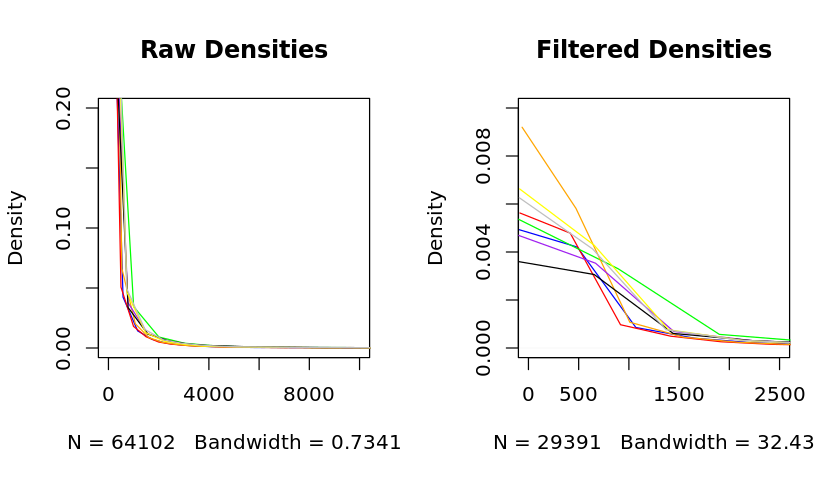

In [19]:
options(repr.plot.height=4, repr.plot.width=7)
par(mfrow=c(1,2))

plot(density(as.data.frame(counts(dds.original))$SRR1039508), xlim = c(0, 10000), ylim = c(0, .2), main = "Raw Densities", col = "Blue")
lines(density(as.data.frame(counts(dds.original))$SRR1039509), col = "Red")
lines(density(as.data.frame(counts(dds.original))$SRR1039512), col = "Green")
lines(density(as.data.frame(counts(dds.original))$SRR1039513), col = "Orange")
lines(density(as.data.frame(counts(dds.original))$SRR1039516), col = "Purple")
lines(density(as.data.frame(counts(dds.original))$SRR1039517), col = "Black")
lines(density(as.data.frame(counts(dds.original))$SRR1039520), col = "Yellow")
lines(density(as.data.frame(counts(dds.original))$SRR1039521), col = "Gray")

plot(density(as.data.frame(counts(dds))$SRR1039508), xlim = c(0, 2500), ylim = c(0, .01), main = "Filtered Densities", col = "Blue")
lines(density(as.data.frame(counts(dds))$SRR1039509), col = "Red")
lines(density(as.data.frame(counts(dds))$SRR1039512), col = "Green")
lines(density(as.data.frame(counts(dds))$SRR1039513), col = "Orange")
lines(density(as.data.frame(counts(dds))$SRR1039516), col = "Purple")
lines(density(as.data.frame(counts(dds))$SRR1039517), col = "Black")
lines(density(as.data.frame(counts(dds))$SRR1039520), col = "Yellow")
lines(density(as.data.frame(counts(dds))$SRR1039521), col = "Gray")

As we can see, **the count densities before and after filtration are radically different**, even with the raw densities portrayed over radically larger axis ranges.  The reason for this divergence is that over 30,000 zero-count genes have shifted the density so that almost all of the area under the curve is near 0.

These 0-genes do not contribute meaningful information to our analysis (and can even bias some of our analytical techniques) so we remove them.

**Note**: For differential expression analysis later, filtering is 
allowable but not necessary if using [Independent Hypothesis Weighting](http://www.bioconductor.org/packages/IHW),
as is the default behavior of `DESeq2`. Independent hypothesis weighting (IHW) is a multiple testing procedure that increases power compared to the method of Benjamini and Hochberg by assigning data-driven weights to each hypothesis.

## Data Transformation

Why transform the data? Many common statistical methods for *exploratory* analysis of
multidimensional data, for example clustering and *principal
components analysis* (PCA), **work best for data that generally has the
same range of variance at different ranges of the mean values**. When
the expected amount of variance is approximately the same across
different mean values, the data is said to be *homoskedastic*. For
RNA-seq counts, however, the expected variance grows with the mean. For
example, **if one performs PCA directly on a matrix of
counts or normalized counts (e.g. correcting for differences in
sequencing depth), the resulting plot typically depends mostly
on the genes with *highest* counts because they show the largest
absolute differences between samples**. 

### The log, rlog, and variance stabilizing transformations

A simple and often used strategy to avoid this is to take the logarithm of the normalized
count values plus a pseudocount of 1 (to account for 0-count observations, as the log of 0 is undefined and the log of 1 is always 0 irrespective of base); however, depending on the
choice of pseudocount, the genes with the very *lowest* counts
will contribute a great deal of noise to the resulting plot, because
taking the logarithm of small counts actually inflates their variance.
We can quickly show this property of counts with simulated
data (here, Poisson-distributed counts with a range of lambda from 0.1 to 100).
We plot the standard deviation of each row (genes) against the mean:

In [ ]:
options(repr.plot.height=3, repr.plot.width=5)
lambda <- 10^seq(from = -1, to = 2, length = 1000)
cts <- matrix(rpois(1000*100, lambda), ncol = 100)
library(vsn)
meanSdPlot(cts, ranks = FALSE)

And for logarithm-transformed counts:

In [ ]:
options(repr.plot.height=3, repr.plot.width=5)
log.cts.one <- log2(cts + 1)
meanSdPlot(log.cts.one, ranks = FALSE)

**Note the markedly lower scale of the axes in the log-transformed data!**

The logarithm with a small pseudocount (i.e. the standard log2(x+1) transformation) amplifies differences when the values are close to 0. The low count genes with low signal-to-noise ratio will then overly contribute to sample-sample distances and PCA plots.

As a solution, DESeq2 offers two transformations for count data that stabilize the variance across the mean: 
+ the regularized-logarithm transformation or rlog (Love, Huber, Anders, Genome Biology 2014)
+ the variance stabilizing transformation (VST) for negative binomial data with a dispersion-mean trend (Anders and Huber, Genome Biology 2010), implemented in the vst function.

For genes with high counts, the rlog and VST will give similar result to the ordinary log2 transformation of normalized counts. For genes with lower counts, the values are shrunken towards the genes' averages across all samples. The rlog-transformed or VST data then becomes approximately homoskedastic, and can be used directly for computing distances between samples, making PCA plots, or as input to downstream methods which perform best with homoskedastic data.

**Which transformation to choose?** 
The rlog tends to work well on small datasets (n < 30), sometimes outperforming the VST when there is a large range of sequencing depth across samples (an order of magnitude difference). 
The VST is much faster to compute and is less sensitive to high count outliers than the rlog. 
*We therefore recommend the VST for large datasets (hundreds of samples).* You can perform both transformations and compare the meanSdPlot or PCA plots generated, as described below.

**Using transformed or normalized counts is only for visualizing and exploring data -- statistical analysis packages like DESeq2 and edgeR should be used with raw counts matrices**


In [ ]:
### Comparing transformation approaches

First, we can look at the the untransformed data. Note the extreme outliers and leverage points in the upper right of the plot, each colored dark blue to show that only one gene falls within each point - these observations would cause a great deal of bias in the result if uncorrected:

,SRR1039508,SRR1039509,SRR1039512,SRR1039513,SRR1039516,SRR1039517,SRR1039520,SRR1039521
ENSG00000000003,679,448,873,408,1138,1047,770,572
ENSG00000000419,467,515,621,365,587,799,417,508
ENSG00000000457,260,211,263,164,245,331,233,229


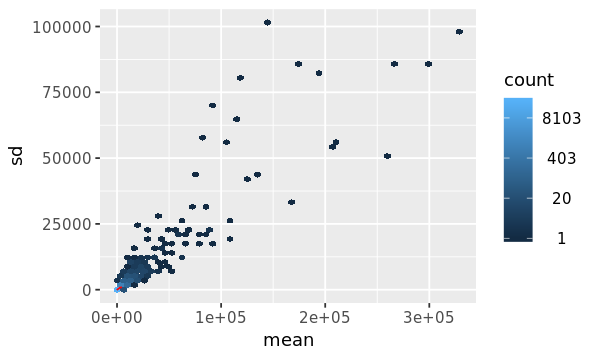

In [22]:
suppressPackageStartupMessages(library(vsn))
options(repr.plot.height=3, repr.plot.width=5)
par(mfrow=c(1,2))
meanSdPlot(assay(dds), ranks=FALSE)

Now we will implement the `rlog` function:

,SRR1039508,SRR1039509,SRR1039512,SRR1039513,SRR1039516,SRR1039517,SRR1039520,SRR1039521
ENSG00000000003,9.385681,9.052599,9.516877,9.285335,9.839093,9.530313,9.663260,9.277695
ENSG00000000419,8.869611,9.138274,9.036117,9.075296,8.972125,9.131828,8.861529,9.060906
ENSG00000000457,7.961373,7.881385,7.824075,7.921493,7.751690,7.886441,7.957126,7.912125


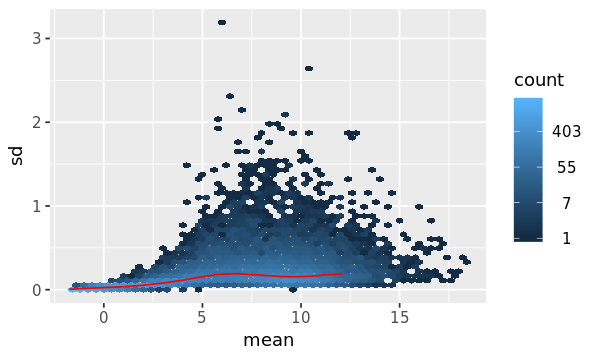

In [23]:
options(repr.plot.height=3, repr.plot.width=5)
rld <- rlog(dds, blind = FALSE)
head(assay(rld), 3)
meanSdPlot(assay(rld), ranks=FALSE)

In [ ]:
Now we will implement the `vst` function:

,SRR1039508,SRR1039509,SRR1039512,SRR1039513,SRR1039516,SRR1039517,SRR1039520,SRR1039521
ENSG00000000003,9.742074,9.430420,9.867626,9.645844,10.183143,9.880416,10.010366,9.639782
ENSG00000000419,9.333668,9.581706,9.486145,9.523093,9.427283,9.574860,9.325998,9.509246
ENSG00000000457,8.765274,8.698448,8.651473,8.732426,8.592786,8.702673,8.761945,8.724101


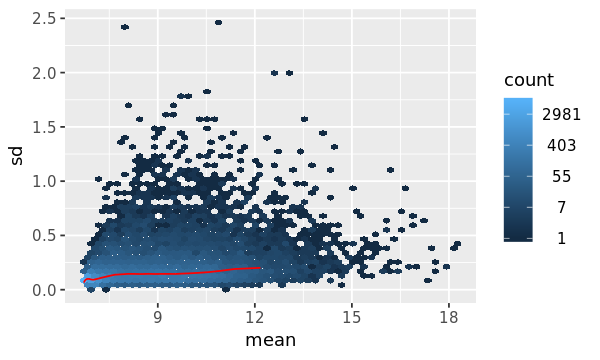

In [24]:
vsd <- vst(dds, blind = FALSE)
head(assay(vsd), 3)
meanSdPlot(assay(vsd), ranks=FALSE)

In the above function calls, we specified `blind = FALSE`, which means
that differences between cell lines and treatment (the variables in
the design) will not contribute to the expected variance-mean trend of
the experiment. The experimental design is not used directly in the
transformation, only in estimating the global amount of variability in
the counts.  For a fully *unsupervised* transformation, one can set
`blind = TRUE` (which is the default).

To show the effect of the transformation, in the figure below
we plot the first sample
against the second, first simply using the *log2* function (after adding
1, to avoid taking the log of zero, which as previously mentioned is undefined and would cause an error), and then using the rlog- and VST-transformed
values. **For the *log2* approach, we need to first estimate *size factors* to
account for sequencing depth**, and then specify `normalized=TRUE`.
Sequencing depth correction is done automatically for the *rlog*
and the *vst*.

In [25]:
dds <- estimateSizeFactors(dds)

In [26]:
ddsESF <- estimateSizeFactors(dds)
df1 <- data.frame(log2(counts(ddsESF, normalized=TRUE)[, 1:2] + 1))
df1$transformation <- "log2(x + 1)"
df2 <- data.frame(assay(rld)[, 1:2])
df2$transformation <- "rld"
df3 <- data.frame(assay(vsd)[, 1:2])
df3$transformation <- "vsd"
df <- rbind(df1, df2, df3)
colnames(df)[1:2] <- c("x", "y")
head(df)
table(df$transformation)

,x,y,transformation
ENSG00000000003,9.375722,8.968399,log2(x + 1)
ENSG00000000419,8.836718,9.169098,log2(x + 1)
ENSG00000000457,7.994317,7.885375,log2(x + 1)
ENSG00000000460,5.897577,5.962838,log2(x + 1)
ENSG00000000938,0.000000,0.000000,log2(x + 1)
ENSG00000000971,11.633403,12.003610,log2(x + 1)



log2(x + 1)         rld         vsd 
      29391       29391       29391 

Now we can make some scatterplots of the log2 (left), rlog (middle), and VST (right) transformed counts. While the rlog is on roughly the same scale as the log2 counts, the VST has a upward shift for the smaller values. It is the differences between samples (deviation from y=x in these scatterplots) which will contribute to the distance calculations and the PCA plot.

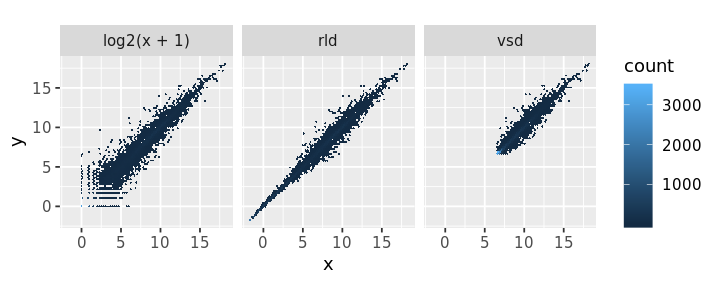

In [27]:
options(repr.plot.width=6, repr.plot.height=2.5)
library(ggplot2)
ggplot(df, aes(x = x, y = y)) + geom_hex(bins = 80) +
  coord_fixed() + facet_grid( . ~ transformation)  

We can see how genes with low counts (bottom left-hand corner) are highly variable on the ordinary logarithmic scale, while the rlog transform and VST compress differences for the low count genes. Since these low-count values are likely artefacts introduced by error or random chance, their exclusion helps to prevent false positives.



## Boxplots of transformed distributions

Boxplots of the count distributions in each sample are a good way to understand the effects these transformations have at the level of individual subjects.

In R's boxplots, points classified as outliers are shown on the plots as circles.  Here, neither the log2 nor the rld transformations include any outliers, while the vsd transformations do have outliers at the upper end of the distributions.  These points are classified as outliers because the vsd method compresses lower end points more substantially, as can be seen on the scatter plot above - the actual magnitude of these points does not significantly exceed the magnitude seen with the other transformations.

we like these too

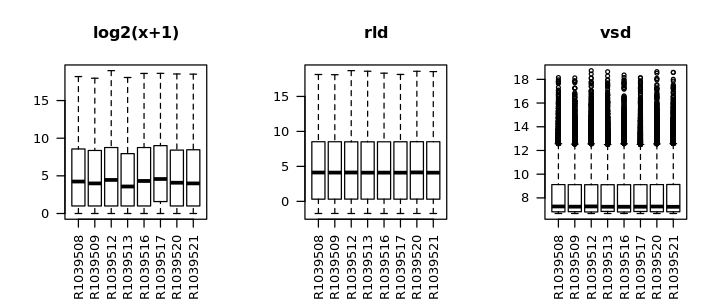

In [28]:
par(mfrow=c(1,3))
boxplot(log2(assay(ddsESF)+1), las=2, main="log2(x+1)")
boxplot(assay(rld), las=2, main="rld")
boxplot(assay(vsd), las=2, main="vsd")

# Sample distances

## The importance of distances

Add some density plots too (to the section above w the boxplots).

Now we are getting into more of the data exploring. This section should start w box & density plots.
Then move to gene bar plots for specific genes of interest (for example, if you knocked out a gene or whatever).
Could talk about a few house-keeping genes (but they might not always play nicely in RNAseq data -- just look anyway and get a handle on whats happening)

Might want to move the distances thing as like an 'alert' -- we can use dim reduc method to look at distances.


High-dimensional data are complex and impossible to visualize in raw form. They represent
thousands of dimensions, but we can only visualize 2-3.

start w the heatmap, and then get into the details about how its calculated

Next part would be the PCA stuff (Jordan will probably jump in here).

All clustering and classification of samples and/or genes involves
combining or identifying objects that are close or similar. Distances 
or similarities are mathematical representations of what we mean by 
close or similar. The choice of distance is important and varies for different subject areas and types of data.

See: http://master.bioconductor.org/help/course-materials/2002/Summer02Course/Distance/distance.pdf

## Distances for exploratory RNA-seq data analysis

A useful first step in an RNA-seq analysis is often to assess overall
similarity between samples: Which samples are similar to each other,
which are different? Does this fit to the expectation from the
experiment's design?

We use the R function *dist* to calculate the "Euclidean distance"
between samples; the Euclidean distance is simply the higher-dimensional analogue of the human-measurable distance between points in 2 or 3 dimensions.  To ensure we have a roughly equal contribution from
all genes, we calculate it from the rlog-transformed data. We need to
transpose the matrix of values using `t`, because the `dist` function
expects the different samples to be **rows** of its argument, and
different dimensions (here, genes) to be **columns**.

unrelated to this workshop: look into pcaexplorer package in R.

In [29]:
sampleDists <- dist(t(assay(rld)))
sampleDists

           SRR1039508 SRR1039509 SRR1039512 SRR1039513 SRR1039516 SRR1039517
SRR1039509   45.70157                                                       
SRR1039512   39.25600   54.91229                                            
SRR1039513   62.63599   44.53085   48.72888                                 
SRR1039516   44.50962   59.06803   43.58242   63.74707                      
SRR1039517   64.49868   51.45303   59.23397   49.88394   47.48509           
SRR1039520   39.58027   57.46654   36.74746   58.49397   46.41179   63.60395
SRR1039521   63.36521   45.06068   57.87997   36.49799   65.55042   52.32104
           SRR1039520
SRR1039509           
SRR1039512           
SRR1039513           
SRR1039516           
SRR1039517           
SRR1039520           
SRR1039521   50.13745

We visualize the distances in a heatmap in a figure below, using the function
`pheatmap` from the [pheatmap](https://cran.r-project.org/web/packages/pheatmap/index.html) package.

In [30]:
library(pheatmap)
library(RColorBrewer)

In order to plot the sample distance matrix with the rows/columns
arranged by the distances in our distance matrix,
we manually provide `sampleDists` to the `clustering_distance`
argument of the `pheatmap` function.
Otherwise the `pheatmap` function would assume that the matrix contains
the data values themselves, and would calculate distances between the
rows/columns of the distance matrix, which is not desired.
We also manually specify a blue color palette using the
`colorRampPalette` function from the [RColorBrewer](https://cran.r-project.org/web/packages/RColorBrewer/index.html) package (this coloring step is optional and is determined by user preference).

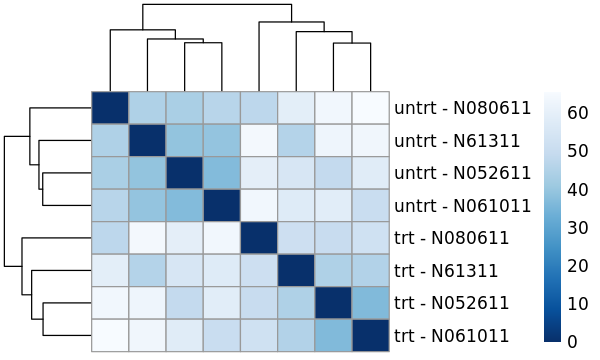

In [31]:
options(repr.plot.height=3, repr.plot.width=5)
sampleDistMatrix <- as.matrix( sampleDists )
rownames(sampleDistMatrix) <- paste( rld$dex, rld$cell, sep = " - " )
colnames(sampleDistMatrix) <- NULL
colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)
pheatmap(sampleDistMatrix,
         clustering_distance_rows = sampleDists,
         clustering_distance_cols = sampleDists,
         col = colors)

**Heatmap of sample-to-sample distances using the rlog-transformed values.**

Note that we have changed the row names of the distance matrix to
contain treatment type and patient number instead of sample ID, so
that we have all this information in view when looking at the heatmap.

Another option for calculating sample distances is to use the
Poisson Distance, implemented in the
[PoiClaClu](https://cran.r-project.org/web/packages/PoiClaClu/index.html) CRAN package.
This measure of dissimilarity between counts
also takes the inherent variance
structure of counts into consideration when calculating the distances
between samples. The `PoissonDistance` function takes the original
count matrix (not normalized) with samples as rows instead of columns,
so we need to transpose the counts in `dds`.

In [32]:
library(PoiClaClu)
poisd <- PoissonDistance(t(counts(ddsESF)))

We plot the heatmap below.

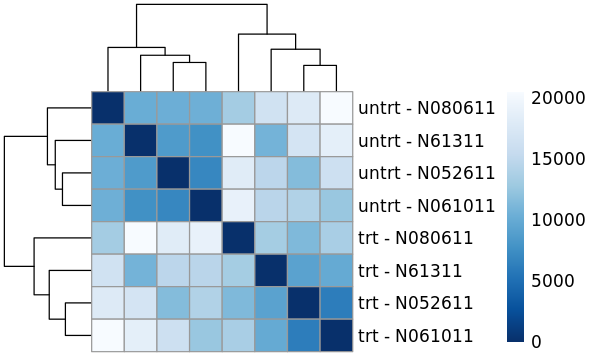

In [33]:
options(repr.plot.height=3, repr.plot.width=5)
samplePoisDistMatrix <- as.matrix( poisd$dd )
rownames(samplePoisDistMatrix) <- paste( rld$dex, rld$cell, sep=" - " )
colnames(samplePoisDistMatrix) <- NULL
pheatmap(samplePoisDistMatrix,
         clustering_distance_rows = poisd$dd,
         clustering_distance_cols = poisd$dd,
         col = colors)

**Heatmap of sample-to-sample distances using the *Poisson Distance*.**

## PCA plot

PCA vs MDS? What to use when. How do we define outliers? Don't get too technical, just mention why you'd use one over the other. One technical question that hasn't been answered - what sort of sample sizes do you need to be able to say that a sample is an outlier? We tend to tell people to keep these 'outliers' since they only have like, 3 samples.
Take the loadings on every PCA and convert those to a set of genes and then throw them onto a pathway analysis or whatever -- add the stuff from CK's data maybe. 'a sense of directionality on the PCs (?)' what genes or pathways are increasing/decreasing as you move along a PC. There's maybe not a super structured approach re: how to deal with outliers. So, is there a utility to using PCA vs MDS when you have small samples size? Look at the data  a few ways before you deicde to throw things out. Ashok wants Jordan to make an R package for exploratory data analysis.

Toss the appendices for now, want to add things about gene annotations but maybe that can go on the second workshop.

Another way to visualize sample-to-sample distances is a
principal components analysis (PCA). In this ordination method, the
data points (here, the samples) are projected onto the 2D plane
such that they spread out in the two directions that explain most of
the differences (figure below). The x-axis is the direction that separates the data
points the most. The values of the samples in this direction are
written *PC1* ("principal component 1"). The y-axis is a direction (it must be *orthogonal* - perpendicular - to
the first direction) that separates the data the second most. The
values of the samples in this direction are written *PC2*.
The percent of the total variance that is contained in the direction
is printed in the axis label. Note that these percentages do not add to
100%, because there are more dimensions - often many of them - that contain the remaining
variance (although each of these remaining dimensions will by definition explain
less than the two that we see).

DataFrame with 8 rows and 10 columns
           SampleName     cell      dex    albut        Run avgLength
             <factor> <factor> <factor> <factor>   <factor> <integer>
SRR1039508 GSM1275862   N61311    untrt    untrt SRR1039508       126
SRR1039509 GSM1275863   N61311      trt    untrt SRR1039509       126
SRR1039512 GSM1275866  N052611    untrt    untrt SRR1039512       126
SRR1039513 GSM1275867  N052611      trt    untrt SRR1039513        87
SRR1039516 GSM1275870  N080611    untrt    untrt SRR1039516       120
SRR1039517 GSM1275871  N080611      trt    untrt SRR1039517       126
SRR1039520 GSM1275874  N061011    untrt    untrt SRR1039520       101
SRR1039521 GSM1275875  N061011      trt    untrt SRR1039521        98
           Experiment    Sample    BioSample        sizeFactor
             <factor>  <factor>     <factor>         <numeric>
SRR1039508  SRX384345 SRS508568 SAMN02422669  1.02364764926706
SRR1039509  SRX384346 SRS508567 SAMN02422675 0.896166721793923
SRR1039512 

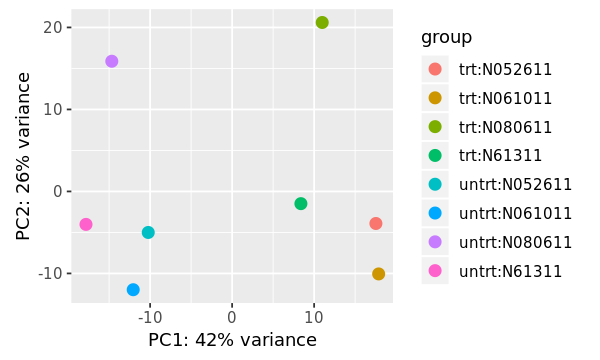

In [34]:
colData(rld)
plotPCA(rld, intgroup = c("dex", "cell"))

**PCA plot using the rlog-transformed values.** Each unique combination of
treatment and cell line is given its own color.

Here, we have used the function `plotPCA()` that comes with *DESeq2*.
The two terms specified by `intgroup` are the interesting groups for
labeling the samples; they tell the function to use them to choose
colors. We can also build the PCA plot from scratch using the
[ggplot2](https://cran.r-project.org/web/packages/ggplot2/index.html) package.
This is done by asking the `plotPCA()` function
to return the data used for plotting rather than building the plot.
See the *ggplot2* [documentation](http://docs.ggplot2.org/current/)
for more details on using `ggplot()`.

In [35]:
pcaData <- plotPCA(rld, intgroup = c( "dex", "cell"), returnData = TRUE)
pcaData
percentVar <- round(100 * attr(pcaData, "percentVar"))

,PC1,PC2,group,dex,cell,name
SRR1039508,-17.818478,-4.021260,untrt:N61311,untrt,N61311,SRR1039508
SRR1039509,8.388115,-1.491329,trt:N61311,trt,N61311,SRR1039509
SRR1039512,-10.227671,-5.004222,untrt:N052611,untrt,N052611,SRR1039512
SRR1039513,17.533464,-3.910088,trt:N052611,trt,N052611,SRR1039513
SRR1039516,-14.672156,15.874223,untrt:N080611,untrt,N080611,SRR1039516
SRR1039517,10.988342,20.599713,trt:N080611,trt,N080611,SRR1039517
SRR1039520,-12.060845,-11.986221,untrt:N061011,untrt,N061011,SRR1039520
SRR1039521,17.869229,-10.060816,trt:N061011,trt,N061011,SRR1039521


We can then use this structure to build up a second plot in a figure below, specifying that the
color of the points should reflect dexamethasone treatment and the
shape should reflect the cell line.

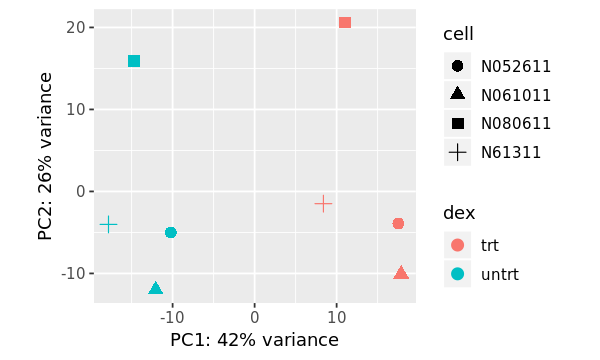

In [36]:
ggplot(pcaData, aes(x = PC1, y = PC2, color = dex, shape = cell)) +
  geom_point(size =3) +
  xlab(paste0("PC1: ", percentVar[1], "% variance")) +
  ylab(paste0("PC2: ", percentVar[2], "% variance")) +
  coord_fixed()

**PCA plot using the rlog-transformed values with custom *ggplot2* code.**
Here we specify cell line (plotting symbol) and dexamethasone treatment (color).

From the PCA plot, we see that the differences between cells (the
different plotting shapes) are considerable, though not stronger than the differences due to
treatment with dexamethasone (red vs blue color). This shows why it will be important to
account for this in differential testing by using a paired design
("paired", because each dex treated sample is paired with one
untreated sample from the *same* cell line). We are already set up for
this design by assigning the formula `~ cell + dex` earlier when specifying our model.

## MDS plot

Another plot, very similar to the PCA plot, can be made using the 
*multidimensional scaling* (MDS) function in base R. This is useful when we
don't have a matrix of data, but only a matrix of distances. Here we
compute the MDS for the distances calculated from the *rlog*
transformed counts and plot these in a figure below.

This method, unlike PCA, does not show the percent of variance explained by the individual components.

**MDS plot using rlog-transformed values.**

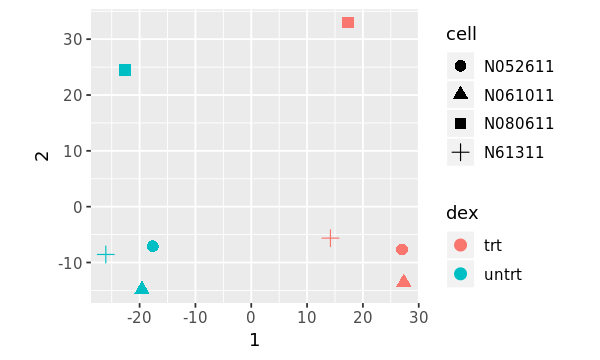

In [37]:
mds <- cbind(as.data.frame(colData(rld)), cmdscale(sampleDistMatrix))
ggplot(mds, aes(x = `1`, y = `2`, color = dex, shape = cell)) +
  geom_point(size = 3) + coord_fixed()

In the figure below we show the same plot for the *PoissonDistance*.  Note the difference in axis scale.

**MDS plot using the *Poisson Distance*.**

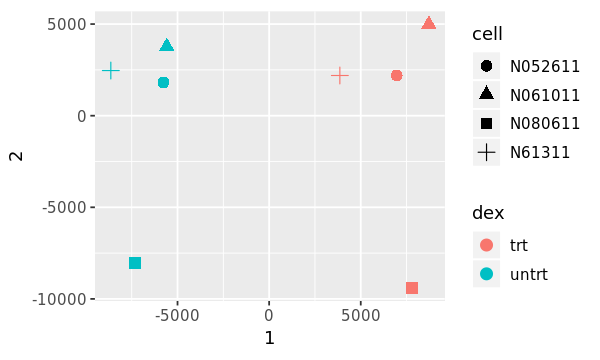

In [38]:
mdsPois <- cbind(as.data.frame(colData(ddsESF)),
   cmdscale(samplePoisDistMatrix))
ggplot(mdsPois, aes(x = `1`, y = `2`, color = dex, shape = cell)) +
  geom_point(size = 3) + coord_fixed()

PCA preserves the covariance of the data, while MDS preserves the distance between the data points.  Depending on what type of distance you use for your MDS analysis, these two results can be the same (if Euclidean distance is used) or different.  Here, we have used the Poisson distance (since it takes the structure of the variance into account), so the MDS and PCA results are not the same.

# Appendices <a name="appendices"></a>

# Appendix A

### Interaction terms

Here is an example again of a single predictor, but with more groups

In [39]:
group <- factor(c(1,1,2,2,3,3))
model.matrix(~ group)

,(Intercept),group2,group3
1,1,0,0
2,1,0,0
3,1,1,0
4,1,1,0
5,1,0,1
6,1,0,1


The _baseline_ or _reference_ group is the one that other groups are contrasted against. You can change the baseline group:

In [40]:
group <- factor(c(1,1,2,2,3,3))
group <- relevel(x=group, ref=3)
model.matrix(~ group)

,(Intercept),group1,group2
1,1,1,0
2,1,1,0
3,1,0,1
4,1,0,1
5,1,0,0
6,1,0,0


Here, we demonstrate manually adding interaction terms:

In [41]:
model.matrix(~ diet + sex + diet:sex)

,(Intercept),diet2,sexm,diet2:sexm
1,1,0,0,0
2,1,0,0,0
3,1,0,1,0
4,1,0,1,0
5,1,1,0,0
6,1,1,0,0
7,1,1,1,1
8,1,1,1,1


The result is the same as using the \* operator:

In [42]:
model.matrix(~ diet * sex)

,(Intercept),diet2,sexm,diet2:sexm
1,1,0,0,0
2,1,0,0,0
3,1,0,1,0
4,1,0,1,0
5,1,1,0,0
6,1,1,0,0
7,1,1,1,1
8,1,1,1,1


# Appendix B

### Additional options for mapping transcripts to genes

**Option 1.** Bioconductor `TxDb.*` packages, which are available for a number of model species (search for "TxDb" at https://bioconductor.org/packages/3.6/data/annotation/). These are slightly less convenient for this purpose than the Ensembl packages. For example, there is a TxDb package Mus Musculus from UCSC build mm10 based on the knownGene Track:

In [43]:
library(TxDb.Mmusculus.UCSC.mm10.knownGene)
txdb <- TxDb.Mmusculus.UCSC.mm10.knownGene
keytypes(txdb)
k <- keys(txdb, "TXNAME")
columns(txdb)
tx4gene <- select(txdb, keys=k, keytype="TXNAME", column="GENEID")

Loading required package: GenomicFeatures
Loading required package: AnnotationDbi


[1] "CDSID"    "CDSNAME"  "EXONID"   "EXONNAME" "GENEID"   "TXID"     "TXNAME"

[1] "CDSCHROM"   "CDSEND"     "CDSID"      "CDSNAME"    "CDSSTART"  
 [6] "CDSSTRAND"  "EXONCHROM"  "EXONEND"    "EXONID"     "EXONNAME"  
[11] "EXONRANK"   "EXONSTART"  "EXONSTRAND" "GENEID"     "TXCHROM"   
[16] "TXEND"      "TXID"       "TXNAME"     "TXSTART"    "TXSTRAND"  
[21] "TXTYPE"

'select()' returned 1:1 mapping between keys and columns


In [44]:
genes(txdb)
exonsBy(txdb)

GRanges object with 24044 ranges and 1 metadata column:
            seqnames              ranges strand |     gene_id
               <Rle>           <IRanges>  <Rle> | <character>
  100009600     chr9   21062393-21075496      - |   100009600
  100009609     chr7   84940169-84964009      - |   100009609
  100009614    chr10   77711446-77712009      + |   100009614
  100009664    chr11   45808083-45842878      + |   100009664
     100012     chr4 144157556-144162651      - |      100012
        ...      ...                 ...    ... .         ...
      99889     chr3   84496093-85887518      - |       99889
      99890     chr3 110246104-110250999      - |       99890
      99899     chr3 151730923-151749959      - |       99899
      99929     chr3   65528447-65555518      + |       99929
      99982     chr4 136550533-136602723      - |       99982
  -------
  seqinfo: 66 sequences (1 circular) from mm10 genome

GRangesList object of length 63759:
$1 
GRanges object with 8 ranges and 3 metadata columns:
      seqnames          ranges strand |   exon_id   exon_name exon_rank
         <Rle>       <IRanges>  <Rle> | <integer> <character> <integer>
  [1]     chr1 4807893-4807982      + |         1        <NA>         1
  [2]     chr1 4808455-4808486      + |         2        <NA>         2
  [3]     chr1 4828584-4828649      + |         3        <NA>         3
  [4]     chr1 4830268-4830315      + |         4        <NA>         4
  [5]     chr1 4832311-4832381      + |         5        <NA>         5
  [6]     chr1 4837001-4837074      + |         6        <NA>         6
  [7]     chr1 4839387-4839488      + |         7        <NA>         7
  [8]     chr1 4840956-4842827      + |         9        <NA>         8

$2 
GRanges object with 9 ranges and 3 metadata columns:
      seqnames          ranges strand | exon_id exon_name exon_rank
  [1]     chr1 4807893-4807982      + |       1      <NA>    

**Option 2.** Find a TxDb from AnnotationHub

This opens up more annotation files from different sources. First find and choose a TxDb database:

In [45]:
suppressPackageStartupMessages(library(AnnotationHub))
ah <- AnnotationHub()
query(ah, "TxDb")
txdb <- ah[["AH52245"]] #TxDb.Athaliana.BioMart.plantsmart22.sqlite

updating metadata: retrieving 1 resource
snapshotDate(): 2018-04-30


AnnotationHub with 59 records
# snapshotDate(): 2018-04-30 
# $dataprovider: UCSC
# $species: Rattus norvegicus, Gallus gallus, Macaca mulatta, Caenorhabditis...
# $rdataclass: TxDb
# additional mcols(): taxonomyid, genome, description,
#   coordinate_1_based, maintainer, rdatadateadded, preparerclass, tags,
#   rdatapath, sourceurl, sourcetype 
# retrieve records with, e.g., 'object[["AH52245"]]' 

            title                                        
  AH52245 | TxDb.Athaliana.BioMart.plantsmart22.sqlite   
  AH52246 | TxDb.Athaliana.BioMart.plantsmart25.sqlite   
  AH52247 | TxDb.Athaliana.BioMart.plantsmart28.sqlite   
  AH52248 | TxDb.Btaurus.UCSC.bosTau8.refGene.sqlite     
  AH52249 | TxDb.Celegans.UCSC.ce11.refGene.sqlite       
  ...       ...                                          
  AH61796 | TxDb.Mmulatta.UCSC.rheMac8.refGene.sqlite    
  AH61797 | TxDb.Ptroglodytes.UCSC.panTro4.refGene.sqlite
  AH61798 | TxDb.Rnorvegicus.UCSC.rn5.refGene.sqlite     
  AH61799 | TxDb.

downloading 0 resources
loading from cache 
    ‘/home/ubuntu//.AnnotationHub/58983’


Then use it to create the transcript-gene map:

In [46]:
keytypes(txdb)

[1] "CDSID"    "CDSNAME"  "EXONID"   "EXONNAME" "GENEID"   "TXID"     "TXNAME"

In [47]:
columns(txdb)

[1] "CDSCHROM"   "CDSEND"     "CDSID"      "CDSNAME"    "CDSSTART"  
 [6] "CDSSTRAND"  "EXONCHROM"  "EXONEND"    "EXONID"     "EXONNAME"  
[11] "EXONRANK"   "EXONSTART"  "EXONSTRAND" "GENEID"     "TXCHROM"   
[16] "TXEND"      "TXID"       "TXNAME"     "TXSTART"    "TXSTRAND"

In [48]:
k <- keys(txdb, "TXNAME")
tx5gene <- select(txdb, keys=k, keytype="TXNAME", column="GENEID")
head(tx5gene)

'select()' returned 1:1 mapping between keys and columns


TXNAME,GENEID
AT1G01010.1,AT1G01010
AT1G01040.1,AT1G01040
AT1G01040.2,AT1G01040
AT1G01046.1,AT1G01046
AT1G01073.1,AT1G01073
AT1G01110.2,AT1G01110


**Option 3.** Import a GFF annotation file from somewhere else.

To convert the GFF file these to a TxDb database, use the `makeTxDbFromGFF()` function from the `GenomicFeatures` package:

In [49]:
library(GenomicFeatures)
gffFile <- system.file("extdata", "GFF3_files", "a.gff3", 
                       package="GenomicFeatures")
txdb <- makeTxDbFromGFF(file=gffFile,
            dataSource="partial gtf file for Tomatoes for testing",
            organism="Solanum lycopersicum")
keytypes(txdb)

Import genomic features from the file as a GRanges object ... OK
Prepare the 'metadata' data frame ... OK
Make the TxDb object ... Warning message in .get_cds_IDX(type, phase):
“The "phase" metadata column contains non-NA values for features of type
  exon. This information was ignored.”OK


[1] "CDSID"    "CDSNAME"  "EXONID"   "EXONNAME" "GENEID"   "TXID"     "TXNAME"

In [50]:
columns(txdb)

[1] "CDSCHROM"   "CDSEND"     "CDSID"      "CDSNAME"    "CDSPHASE"  
 [6] "CDSSTART"   "CDSSTRAND"  "EXONCHROM"  "EXONEND"    "EXONID"    
[11] "EXONNAME"   "EXONRANK"   "EXONSTART"  "EXONSTRAND" "GENEID"    
[16] "TXCHROM"    "TXEND"      "TXID"       "TXNAME"     "TXSTART"   
[21] "TXSTRAND"   "TXTYPE"

In [51]:
k <- keys(txdb, "TXNAME")
tx6gene <- select(txdb, keys=k, keytype="TXNAME", column="GENEID")
head(tx5gene)

'select()' returned 1:1 mapping between keys and columns


TXNAME,GENEID
AT1G01010.1,AT1G01010
AT1G01040.1,AT1G01040
AT1G01040.2,AT1G01040
AT1G01046.1,AT1G01046
AT1G01073.1,AT1G01073
AT1G01110.2,AT1G01110


Note, the `GenomicFeatures` package enables you to make a TxDb from a variety of sources:

In [52]:
grep("makeTxDb", ls("package:GenomicFeatures"), val=TRUE)

[1] "makeTxDb"                   "makeTxDbFromBiomart"       
[3] "makeTxDbFromEnsembl"        "makeTxDbFromGFF"           
[5] "makeTxDbFromGRanges"        "makeTxDbFromUCSC"          
[7] "makeTxDbPackage"            "makeTxDbPackageFromBiomart"
[9] "makeTxDbPackageFromUCSC"